# The IQ-OTH/NCCD lung cancer dataset

The Iraq-Oncology Teaching Hospital/National Center for Cancer Diseases (IQ-OTH/NCCD) lung cancer dataset was collected in the above-mentioned specialist hospitals over a period of three months in fall 2019. It includes CT scans of patients diagnosed with lung cancer in different stages, as well as healthy subjects. IQ-OTH/NCCD slides were marked by oncologists and radiologists in these two centers. The dataset contains a total of 1190 images representing CT scan slices of 110 cases. These cases are grouped into three classes: normal, benign, and malignant. of these, 40 cases are diagnosed as malignant; 15 cases diagnosed with benign; and 55 cases classified as normal cases. The CT scans were originally collected in DICOM format. The scanner used is SOMATOM from Siemens. CT protocol includes: 120 kV, slice thickness of 1 mm, with window width ranging from 350 to 1200 HU and window center from 50 to 600 were used for reading. with breath hold at full inspiration. All images were de-identified before performing analysis. Written consent was waived by the oversight review board. The study was approved by the institutional review board of participating medical centers. Each scan contains several slices. The number of these slices range from 80 to 200 slices, each of them represents an image of the human chest with different sides and angles. The 110 cases vary in gender, age, educational attainment, area of residence and living status. Some of them are employees of the Iraqi ministries of Transport and Oil, others are farmers and gainers. Most of them come from places in the middle region of Iraq, particularly, the provinces of Baghdad, Wasit, Diyala, Salahuddin, and Babylon.

[Dataset Link](https://data.mendeley.com/datasets/bhmdr45bh2/4)

# Required libraries

In [1]:
from os import listdir  # to get the files and directories
from os.path import join  # to joint base path with sub path
import numpy as np  # numpy library will help us to work with the numbers and arrays
import matplotlib.pyplot as plt  # to visualize/plot the images
import cv2  # handle the images
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_score,
    recall_score,
    f1_score,
)
import pandas as pd
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Input,
    Dense,
    Conv2D,
    MaxPooling2D,
    Flatten,
    Dropout,
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data Loading

First we need know the classes that we have.

In [2]:
base_path = "./The IQ-OTHNCCD lung cancer dataset/"
# . -> current working directory
categories = listdir(base_path)
print(categories)
# We have 3 classes: Benign, Malignant, Normal

['Bengin cases', 'Malignant cases', 'Normal cases']


Loading images from directory 

In [3]:
images = {}  # to store each class of images in one dictionary
for category in categories:
    images[category] = (
        []
    )  # each class has more than one images and we'll store all in one list
    category_path = join(base_path, category)
    for img_name in listdir(category_path):
        img_path = join(category_path, img_name)
        img = cv2.imread(
            img_path, cv2.IMREAD_GRAYSCALE
        )  # read images in grayscale (one chanel)
        images[category].append(img)

Show sample images from each class

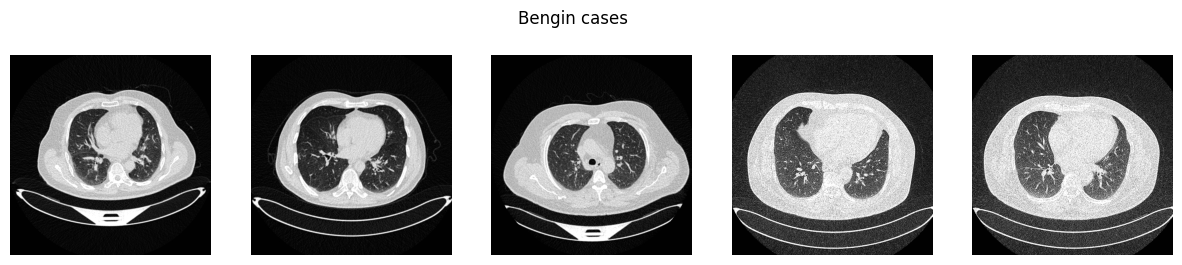

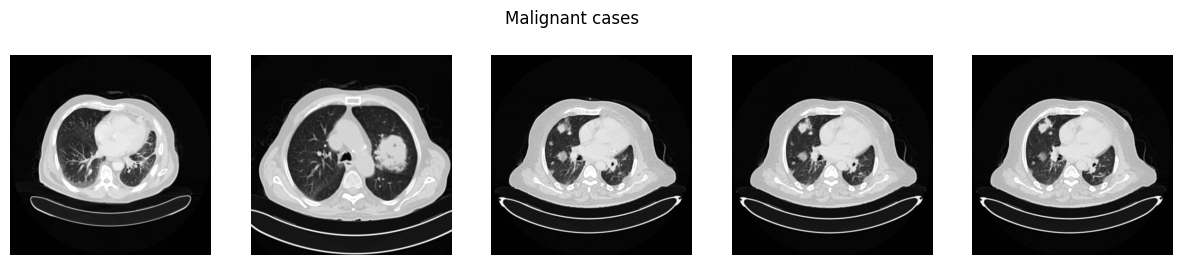

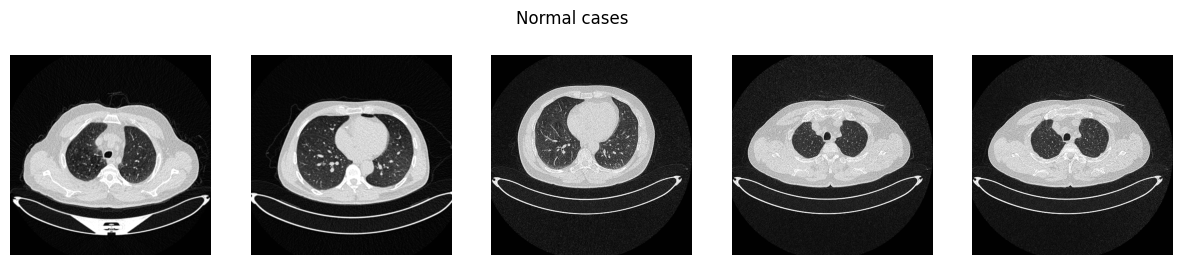

In [4]:
num_images = 5
for category in categories:
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    fig.suptitle(category)
    for i in range(num_images):
        axes[i].imshow(images[category][i], "gray")
        axes[i].axis("off")
    plt.show()

# Image Resizing

Check shape of images

In [5]:
def get_shape_distribution():
    shape_distribution = {}
    for category in categories:
        for img in images[category]:
            if img.shape not in shape_distribution:
                shape_distribution[img.shape] =1
            else:
                shape_distribution[img.shape] +=1
    return shape_distribution

shape_distribution = get_shape_distribution()
print(shape_distribution)

{(512, 512): 1036, (404, 511): 1, (512, 801): 28, (512, 623): 31, (331, 506): 1}


Paper that help us to determine the best interpolation [Analysis of Medical Image Resizing Using Bicubic 
Interpolation Algorithm](https://www.researchgate.net/profile/Bambang-Triwijoyo/publication/351410642_Analysis_of_Medical_Image_Resizing_Using_Bicubic_Interpolation_Algorithm/links/60960966458515d3150432c3/Analysis-of-Medical-Image-Resizing-Using-Bicubic-Interpolation-Algorithm.pdf)

why bicubic interpolation is better than others?
- Because it uses 16 pixels to calculate the new pixel value, it is more accurate than bilinear interpolation which uses only 4 pixels.
  
---

Resize images with bicubic interpolation

In [6]:
sorted_shapes = sorted(shape_distribution.items(), key=lambda x: x[1], reverse=True)
print(sorted_shapes)
majority_shape = sorted_shapes[0][0]
print("Majority Shape:", majority_shape)

[((512, 512), 1036), ((512, 623), 31), ((512, 801), 28), ((404, 511), 1), ((331, 506), 1)]
Majority Shape: (512, 512)


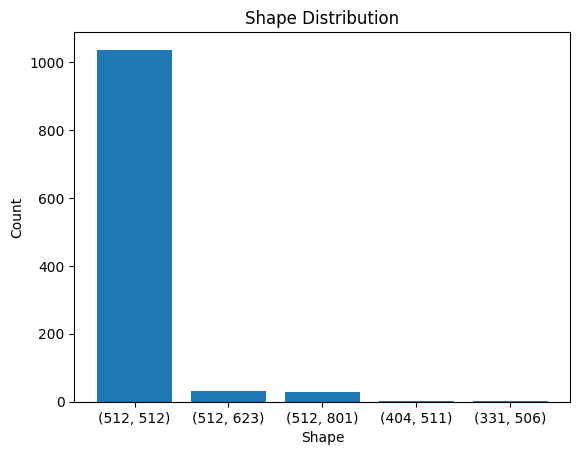

In [7]:
plt.bar(x=[str(i[0]) for i in sorted_shapes], height=[i[1] for i in sorted_shapes])
plt.title("Shape Distribution")
plt.xlabel("Shape")
plt.ylabel("Count")
plt.show()

In [8]:
def resize_images(target_size):
    for category in categories:
        # We need to use enumerate to get the index because we want to edit on the original list and we can't do that without index
        for index, img in enumerate(images[category]):
            if img.shape != target_size:
                images[category][index] = cv2.resize(img, target_size)

resize_images((majority_shape[0]//4, majority_shape[1]//4))
# We choose the majority shape (512, 512) and shrink the image to (128, 128) because training the model with (512, 512) images takes a long time

Check shape distribution after resizing

In [9]:
print(get_shape_distribution())

{(128, 128): 1097}


In [10]:
# Convert the lists to numpy arrays for efficient numerical computations
for category in categories:
    images[category] = np.array(images[category])

# Class Distribution

Check class distribution

Bengin cases : 120
Malignant cases : 561
Normal cases : 416


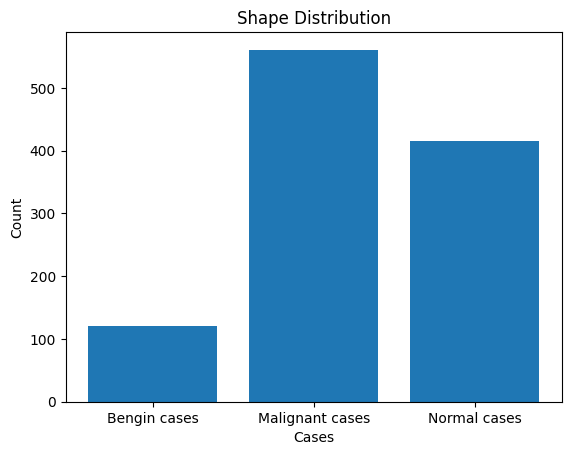

In [11]:
class_distribution = []

for category in categories:
    class_distribution.append(len(images[category]))
    print(category, ":", len(images[category]))

plt.bar(categories, class_distribution)
plt.title("Shape Distribution")
plt.xlabel("Cases")
plt.ylabel("Count")
plt.show()

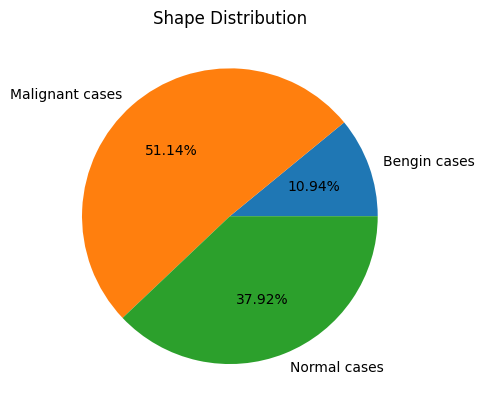

In [12]:
plt.pie(x=class_distribution, labels=categories, autopct="%0.2f%%")
plt.title("Shape Distribution")
plt.show()

$Arithmetic\ Mean\ (AM) = \frac{A + B}{2}$

$Geometric\ Mean\ (GM) = \sqrt{A \times B}$

$Harmonic\ Mean\ (HM) = \frac{2}{\frac{1}{A} + \frac{1}{B}} = \frac{2ab}{a+b} = \frac{GM^2}{AM}$

---

Our data is imbalanced, and we need to handle it.

Imbalanced data is a common challenge in machine learning where the distribution of classes in a dataset is skewed, with one class significantly outnumbering the others. This phenomenon can lead to biased models and reduced performance, posing a substantial problem in various real-world applications. [Imbalanced Data in Machine Learning: A Comprehensive Review](https://www.researchgate.net/publication/376396736_Imbalanced_Data_in_Machine_Learning_A_Comprehensive_Review#:~:text=Imbalanced%20data%20is%20a%20common,in%20various%20real%2Dworld%20applications.)

And there are several ways to handle it, such as:
1. Evaluation Metrics
   - For an imbalanced class dataset, the F1 score is a more appropriate metric. It is the harmonic mean of precision and recall and the expression is 
   $F1 = 2 * \frac{precision * recall}{precision + recall}$.
   - F1 score keeps the balance between precision and recall and improves the score only if the classifier identifies more of a certain class correctly. [Source](https://www.analyticsvidhya.com/blog/2021/06/5-techniques-to-handle-imbalanced-data-for-a-classification-problem/)
2. Resampling Techniques (Modifies data to balance the classes) through:
   <img src ="./images/resampling.png"> \
   [Source: Resampling strategies for imbalanced datasets](https://www.kaggle.com/code/rafjaa/resampling-strategies-for-imbalanced-datasets?scriptVersionId=1756536&cellId=12)
   1. Over-sampling: duplicate random records from the minority class.
   2. Under-sampling: the simplest technique involves removing random records from the majority class [Source](https://www.analyticsvidhya.com/blog/2020/07/10-techniques-to-deal-with-class-imbalance-in-machine-learning/)
3. Data Augmentation: Creates dummy data by transforming existing data. This can be done by applying various transformations such as rotations, reflection, translations, and flips to the existing data. [Source](https://datasciencedojo.com/blog/techniques-to-handle-imbalanced-data/)
   ```py
   # We can use ImageDataGenerator from keras to perform data augmentation 
   from tensorflow.keras.preprocessing.image import ImageDataGenerator
   ```
4. One-Class Classification: One-class classification involves training a model on only one class and then using it to identify data points that do not belong to that class. [Source](https://datasciencedojo.com/blog/techniques-to-handle-imbalanced-data/#:~:text=One%2Dclass%20classification%20involves%20training%20a%20model%20on%20only%20one%20class%20and%20then%20using%20it%20to%20identify%20data%20points%20that%20do%20not%20belong%20to%20that%20class.)

---

# Building the Model

## One-Class Classification 

### Handling Imbalanced Data

First we will try One-Class Classification (Malignant or Non-Malignant[Benign/Normal]) (Majority Class/ The important cases)

In [13]:
# first convert dict_values to list then we'll have list of arrays
X = np.concatenate(list(images.values()))
y = np.concatenate([[category]*len(images[category]) for category in categories])

In [14]:
one_class = ["Malignant cases", "Non-Malignant cases"]
y_one_class = np.where(y == one_class[0], one_class[0], one_class[1])

Counter({'Malignant cases': 561, 'Non-Malignant cases': 536})
[0.4886052871467639, 0.5113947128532361]


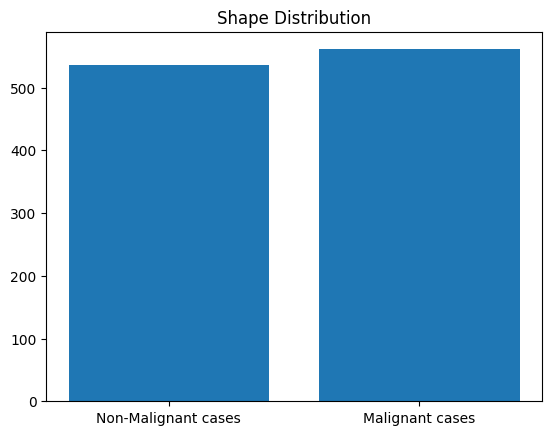

In [15]:
class_distribution = Counter(y_one_class)

print(class_distribution)
# Distribution for each class as ratio per data
print([i/sum(list(class_distribution.values())) for i in class_distribution.values()])
plt.bar(class_distribution.keys(), class_distribution.values())
plt.title("Shape Distribution")
plt.show()

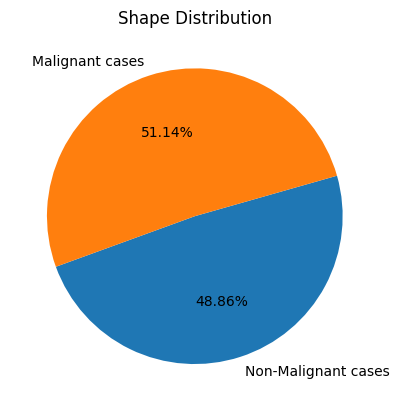

In [16]:
plt.pie(
    class_distribution.values(),
    labels=class_distribution.keys(),
    autopct="%0.2f%%",
    startangle=200,
)
plt.title("Shape Distribution")
plt.show()

Now our dataset after applying One-Class Classification techniques is balanced, and we can proceed to the next step.

### Splitting the Data

Split the data into training and validation sets \
<img src="./images/split.png" width=500>


In [137]:
X_train, X_test, y_train, y_test = train_test_split(X, y_one_class, test_size=0.3, stratify=y_one_class, random_state=42)

In [18]:
class_distribution = Counter(y_train)

print(class_distribution)
print([i/sum(list(class_distribution.values())) for i in class_distribution.values()])

Counter({'Malignant cases': 392, 'Non-Malignant cases': 375})
[0.5110821382007823, 0.48891786179921776]


### Data Encoding

Handle categorical data using [Label Encoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html)

In [19]:
y_train[0]

'Malignant cases'

In [138]:
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

In [21]:
le.classes_

array(['Malignant cases', 'Non-Malignant cases'], dtype='<U19')

### Preparing the data

Reshape the inputs [Keras input_shape for conv2d](https://stackoverflow.com/questions/43895750/keras-input-shape-for-conv2d-and-manually-loaded-images)

In [23]:
(*X_train[0].shape, 1)

(128, 128, 1)

In [139]:
X_train = X_train.reshape(-1,*X_train[0].shape, 1)
X_train.shape

(767, 128, 128, 1)

Nomralizing the data

In [140]:
X_train = X_train / 255.0
X_test = X_test / 255.0

### Creating the model

#### Understanding how to start

- Number of Neurons In Input and Output Layers: \
The number of neurons in the input layer is equal to the number of features in the data and in very rare cases, there will be one input layer for bias. Whereas the number of neurons in the output depends on whether is the model is used as a regressor or classifier. If the model is a regressor then the output layer will have only a single neuron but in case if the model is a classifier it will have a single neuron or multiple neurons depending on the class label of the model. [Soure](https://medium.com/geekculture/introduction-to-neural-network-2f8b8221fbd3)

---

- Choosing Hidden Layers:
    - Well if the data is linearly separable then you don't need any hidden layers at all. 
    - If data is less complex and is having fewer dimensions or features then neural networks with 1 to 2 hidden layers would work.
  - If data is having large dimensions or features then to get an optimum solution, 3 to 5 hidden layers can be used. 
  - It should be kept in mind that increasing hidden layers would also increase the complexity of the model and choosing hidden layers such as 8, 9, or in two digits may sometimes lead to overfitting. \
 [Source](https://www.linkedin.com/pulse/choosing-number-hidden-layers-neurons-neural-networks-sachdev/)
 

**So we will start our model with 3 layers and then we will see if we need to add more layers or not.**
 
---

The main use case of the sigmoid function is as the activation for the output layer of binary classification models. It squashes the output to a probability value between 0 and 1, which can be interpreted as the probability of the input belonging to a particular class. [Source](https://www.datacamp.com/tutorial/introduction-to-activation-functions-in-neural-networks#:~:text=The%20main%20use%20case%20of%20the%20sigmoid%20function%20is%20as%20the%20activation%20for%20the%20output%20layer%20of%20binary%20classification%20models.%20It%20squashes%20the%20output%20to%20a%20probability%20value%20between%200%20and%201%2C%20which%20can%20be%20interpreted%20as%20the%20probability%20of%20the%20input%20belonging%20to%20a%20particular%20class.) 

**So we'll use sigmoid as activation function for the output layer**

---

- A convolutional neural network (CNN) functions better with ReLU in the hidden layers or a variation of that (e.g., parametric, exponential, etc.), whereas a recurrent neural network (RNN) is better suited to sigmoid or tanh. 
[Source](https://encord.com/blog/activation-functions-neural-networks/#:~:text=A%20convolutional%20neural%20network%20(CNN)%20functions%20better%20with%20ReLU%20in%20the%20hidden%20layers%20or%20a%20variation%20of%20that%20(e.g.%2C%20parametric%2C%20exponential%2C%20etc.)%2C%20whereas%20a%20recurrent%20neural%20network%20(RNN)%20is%20better%20suited%20to%20sigmoid%20or%20tanh.%C2%A0)
- The ReLU is the most used activation function in the world right now.Since, it is used in almost all the convolutional neural networks or deep learning. [Source](https://towardsdatascience.com/activation-functions-neural-networks-1cbd9f8d91d6#:~:text=The%20ReLU%20is%20the%20most%20used%20activation%20function%20in%20the%20world%20right%20now.Since%2C%20it%20is%20used%20in%20almost%20all%20the%20convolutional%20neural%20networks%20or%20deep%20learning.)
- Output range of ReLU: [0 to infinity), and because we work with image we don't need negative values.
---

A Convolutional Neural Network is a Deep 
Learning algorithm that can take in image as input, with assigning importance learnable weights and biases to 
various objects inside this image and be capable of differentiating one from the other. In addition, the pre-processing 
required for this technique is much lower if comparing with other classification algorithms. [Source](https://iopscience.iop.org/article/10.1088/1757-899X/928/2/022035/pdf)

The role of ConvNet is to reduce the images into a form that is easier to process, without losing features that are critical for getting a good prediction. This is important when we are to design an architecture that is not only good at learning features but also scalable to massive datasets. [Source](https://saturncloud.io/blog/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way/#:~:text=The%20role%20of%20ConvNet%20is%20to%20reduce%20the%20images%20into%20a%20form%20that%20is%20easier%20to%20process%2C%20without%20losing%20features%20that%20are%20critical%20for%20getting%20a%20good%20prediction.%20This%20is%20important%20when%20we%20are%20to%20design%20an%20architecture%20that%20is%20not%20only%20good%20at%20learning%20features%20but%20also%20scalable%20to%20massive%20datasets.)

---

Dropout layer used to avoid over-fitting and to speed up the training process. \
It's randomly ignore some neurons during training. \
So if we faced the over-fitting problem we'll use it.

---

#### Model structure

In [187]:
model = Sequential()
# Input Layer
model.add(Input(shape=X_train[0].shape))
# Hidden Layers
model.add(Conv2D(filters=64, kernel_size=(3, 3), name="conv2d_1", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2), name="max2d_1"))

model.add(Conv2D(filters=32, kernel_size=(3, 3), name="conv2d_2", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2), name="max2d_2"))

model.add(Conv2D(filters=8, kernel_size=(3, 3), name="conv2d_3", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2), name="max2d_3"))

model.add(Flatten(name="flatten"))

# Output Layer
model.add(Dense(1, activation="sigmoid", name="out"))

model.summary()

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 126, 126, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max2d_1 (MaxPooling2D)          │ (None, 63, 63, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 61, 61, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max2d_2 (MaxPooling2D)          │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 8)      │         2,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max2d_3 (MaxPooling2D)          │ (None, 14, 14, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1568)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ out (Dense)                     │ (None, 1)              │         1,569 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,985 (89.79 KB)

 Trainable params: 22,985 (89.79 KB)

 Non-trainable params: 0 (0.00 B)

#### Model summary explanation

- Output Shape is the shape of the output of the layer 
  - for CNN it is `input shape - filter shape + 1` and number of filters (e.g., in the first CNN layer the input shape is `(128, 128)` and the filter shape is `(3, 3)` so the output shape will be `(128 - 3 + 1, 128 - 3 + 1) = (126, 126, 64))`
  - for MaxPooling it is `input shape / pool size` (e.g., in the first MaxPooling layer the input shape is `(126, 126, 64)` and the pool size is `(2, 2)` so the output shape will be `(126 / 2, 126 / 2, 64) = (63, 63, 64)`
  - for Flatten it is `product of input shape` (e.g., in the Flatten layer the input shape is `(14, 14, 8)` so the output shape will be `14 * 14 * 8 = 1568`)
  - for dense it is `number of neurons` (e.g., in the output layer the number of neurons is `1` so the output shape will be `1`)
- None in the shape means that the layer can accept any number of inputs at time. (when we train the model we can pass any number of images to the model)
- Param # is the number of parameters in the layer
  - for CNN it is `(height * width * depth * number of inputs + 1) * number of filters` (e.g., in the first CNN layer the height is `3`, the width is `3`, the depth is `1` (because the image is grayscale), the number of inputs is `1` (because it is the first layer), and the number of filters is `64` so the number of parameters will be `(3 * 3 * 1 * 1 + 1) * 64 = 640`, the `+ 1` is for the bias (another example in the second CNN layer the height is `3`, the width is `3`, the depth is `64` (because the output of the first CNN layer is `64`), the number of inputs is `64` and the number of filters is `32` so the number of parameters will be `(3 * 3 * 64 * 64 + 1) * 32 = 18464`)
  - for MaxPooling it is `0` because it doesn't have any parameters (it just reduces the size of the input), same for Flatten, no calculations needed, no bias and no learnings.
  - for dense it is `(number of inputs + 1) * number of neurons` (e.g., in the output layer the number of inputs is `1568` (because the output of the Flatten layer is `1568`), the number of neurons is `1` so the number of parameters will be `(1568 + 1) * 1 = 1569`)
---

#### Loss Function

- For a binary classification, binary_crossentropy should be a better choice. [Source](https://stackoverflow.com/questions/44151760/received-a-label-value-of-1-which-is-outside-the-valid-range-of-0-1-python)
- Cross-Entropy/Logistic Loss (CE): Cross entropy loss is also known as logistic loss function. It’s the most common loss for binary classification (two classes 0 and 1). We want to measure the distance from the actual class to the predicted value, which is usually a real number between 0 and 1. We should use the sigmoid activation function as the last layer. [Source](<https://medium.com/@nghihuynh_37300/understanding-loss-functions-for-classification-81c19ee72c2a#:~:text=Cross%2DEntropy/Logistic%20Loss%20(CE)%3A%20Cross%20entropy%20loss%20is%20also%20known%20as%20logistic%20loss%20function.%20It%E2%80%99s%20the%20most%20common%20loss%20for%20binary%20classification%20(two%20classes%200%20and%201).%20We%20want%20to%20measure%20the%20distance%20from%20the%20actual%20class%20to%20the%20predicted%20value%2C%20which%20is%20usually%20a%20real%20number%20between%200%20and%201.>)
<center><img src="./images/log_loss.png" width=400></center>
<center><img src="./images/loss_prob.png" width=400></center>

[Binary Cross-Entropy / Log Loss](https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a#:~:text=what%20you%E2%80%99ll%20find%3A-,Binary%20Cross%2DEntropy%20/%20Log%20Loss,-where%20y%20is)

Since our problem is binary classification, we can say what's the probability of the image to be malignant or not. if the probability is more than 0.5 then the image is malignant, otherwise, it is not.

Binary Cross-Entropy is the loss used for binary classification problem.
Let's break it down:

- $y_i$ is the true label
- $p(y_i)$ is the predicted probability of the true label
- $1 - p(y_i)$ is the predicted probability of the false label
- $\frac{1}{N}\sum_{i=1}^{N}$ for averaging over all samples
- the function consist of two terms, one for each class:

  - $y_i * log(p(y_i))$ for the true class (when $y_i = 1$)
  - $(1 - y_i) * log(1 - p(y_i))$ for the false class (when $y_i = 0$)

  How it works:

  - if the value of $y_i$ is 1, the first term will be calculated and the second term will be ignored
  - if the value of $y_i$ is 0, the second term will be calculated and the first term will be ignored

- $log$ is used to penalize bad predictions if the probability associated with the true class is 1, then the loss is 0, if the probability is close to 0, then the loss is high.
- Negative sign is used to convert the loss to a positive value, because the log of a value between 0 and 1 is negative.

---

#### Optimizer

For image classification we find that the best two optimizers are Adam and RMSprop. [Source](https://www.sciencedirect.com/science/article/pii/S2214785321013316?__cf_chl_tk=J_EiUs0lelcE_23ASR7FCOlnuTAdFaOiFiY9utQeb38-1718391674-0.0.1.1-5311)

For Explanation of the optimizer check these links:
1. [Various Optimization Algorithms For Training Neural Network](https://towardsdatascience.com/optimizers-for-training-neural-network-59450d71caf6#:~:text=for%20image%20classification%20we%20find%20that%20the%20best%20two%20optimizers%20are%20Adam%20and%20RMSprop.)
2. [Adam — latest trends in deep learning optimization.](https://towardsdatascience.com/adam-latest-trends-in-deep-learning-optimization-6be9a291375c)
3. [Understanding RMSprop — faster neural network learning](https://towardsdatascience.com/understanding-rmsprop-faster-neural-network-learning-62e116fcf29a)

---

#### Model compiling

In [188]:
model.compile(
    optimizer="RMSprop", loss="binary_crossentropy", metrics=["accuracy"]
)

#### Model training

- epochs is the number of times the model will train on the entire training dataset (one epoch can be divided into number of iterations)
- batch_size is the number of sample that will be used in each iteration.

$iterations\_per\_one\_epoch = \frac{samples}{batch\_size}\ $ 

In [189]:
history = model.fit(
    X_train,
    y_train_encoded,
    epochs=10,
    batch_size=32,
    validation_data=(X_test, y_test_encoded),
)
model_rms = model

Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 15s 475ms/step - accuracy: 0.5520 - loss: 0.7035 - val_accuracy: 0.7273 - val_loss: 0.6191
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 451ms/step - accuracy: 0.6668 - loss: 0.6073 - val_accuracy: 0.7394 - val_loss: 0.4991
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 452ms/step - accuracy: 0.7214 - loss: 0.5002 - val_accuracy: 0.7939 - val_loss: 0.4397
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 12s 482ms/step - accuracy: 0.7470 - loss: 0.4751 - val_accuracy: 0.8182 - val_loss: 0.4207
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 13s 524ms/step - accuracy: 0.8145 - loss: 0.4057 - val_accuracy: 0.8485 - val_loss: 0.3417
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 12s 492ms/step - accuracy: 0.8572 - loss: 0.3381 - val_accuracy: 0.8788 - val_loss: 0.3137
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 460ms/step - accuracy: 0.8712 - loss: 0.2819 - val_accuracy: 0.9333 - val_loss: 0.2218
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 12s 475ms/step - accuracy: 0.8807 - loss: 0.2469 - val_accu

#### Model evaluation

In [190]:
def plot_accuracy(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend(loc=0)
    plt.show()

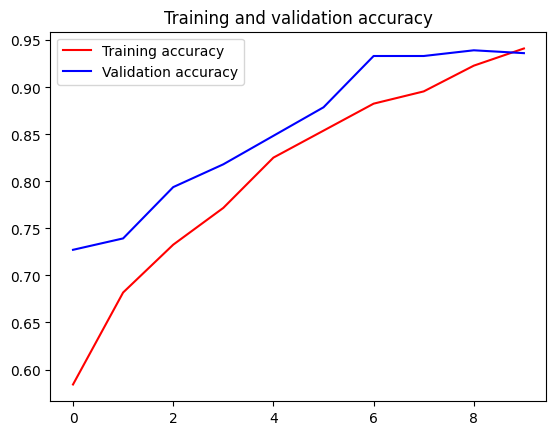

In [191]:
plot_accuracy(history)

In [192]:
model.evaluate(X_test, y_test_encoded)

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - accuracy: 0.9500 - loss: 0.1463


[0.1587286740541458, 0.9363636374473572]

In [200]:
model.evaluate(X_test,y_test_encoded)

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 0.9752 - loss: 0.0539


[0.04064885899424553, 0.9848484992980957]

---

## Under-Sampling

Now we'll try under-sampling technique to handle the imbalanced data and we'll use `RandomUnderSampler` from `imblearn.under_sampling` to do that.
[Resource](https://www.geeksforgeeks.org/handling-imbalanced-data-for-classification/)

In [202]:
# We can't do that directly on the X so we we'll get indices of X_train
indices = np.arange(0, len(X))

In [203]:
undersample = RandomUnderSampler()
indices_under , y_under = undersample.fit_resample(indices.reshape(-1, 1), y)
print("Under-sampled class distribution:", Counter(y_under))

Under-sampled class distribution: Counter({'Bengin cases': 120, 'Malignant cases': 120, 'Normal cases': 120})


Now we need to get train dataset because we don't want to train the model on the all sample from the minority class, so we'll use `train_test_split` from `sklearn.model_selection` to split the data into training and testing sets.

In [204]:
indices_train, y_train = train_test_split(indices_under, y_under, test_size=0.3, stratify=y_under)[::2]

# train_test_split return X_train, X_test, y_train, y_test and we need X_train and y_train so we set the step to 2

indices_train has the indices of the training set and the rest will be the validation

In [212]:
indices_train = indices_train.reshape(-1)

In [72]:
indices_test = np.delete(indices,indices_train)

In [214]:
X_train = X[indices_train]
X_test = X[indices_test]
y_train = y[indices_train]
y_test = y[indices_test]

In [215]:
X_train = X_train.reshape(-1,*X_train[0].shape, 1)
X_test = X_test.reshape(-1,*X_test[0].shape, 1)
X_train.shape

(252, 128, 128, 1)

In [216]:
le2 = LabelEncoder()
y_train_encoded = le2.fit_transform(y_train)
y_test_encoded = le2.transform(y_test)

In [217]:
le2.classes_

array(['Bengin cases', 'Malignant cases', 'Normal cases'], dtype='<U15')

In [218]:
model2 = Sequential()
# Input Layer
model2.add(Input(shape=X_train[0].shape))
# Hidden Layers
model2.add(Conv2D(filters=64, kernel_size=(3, 3), name="conv2d_1", activation="relu"))
model2.add(MaxPooling2D(pool_size=(2, 2), name="max2d_1"))

model2.add(Conv2D(filters=32, kernel_size=(3, 3), name="conv2d_2", activation="relu"))
model2.add(MaxPooling2D(pool_size=(2, 2), name="max2d_2"))

model2.add(Conv2D(filters=8, kernel_size=(3, 3), name="conv2d_3", activation="relu"))
model2.add(MaxPooling2D(pool_size=(2, 2), name="max2d_3"))

model2.add(Flatten(name="flatten"))

# Output Layer
model2.add(Dense(3, activation="softmax", name="out"))

model2.summary()

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 126, 126, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max2d_1 (MaxPooling2D)          │ (None, 63, 63, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 61, 61, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max2d_2 (MaxPooling2D)          │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 8)      │         2,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max2d_3 (MaxPooling2D)          │ (None, 14, 14, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1568)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ out (Dense)                     │ (None, 3)              │         4,707 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,123 (102.04 KB)

 Trainable params: 26,123 (102.04 KB)

 Non-trainable params: 0 (0.00 B)

In [219]:
model2.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

In [220]:
history = model2.fit(
    X_train,
    y_train_encoded,
    epochs=10,
    batch_size=32,
    validation_data=(X_test, y_test_encoded),
)

Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 880ms/step - accuracy: 0.3438 - loss: 9.0476 - val_accuracy: 0.3550 - val_loss: 1.9162
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 775ms/step - accuracy: 0.3786 - loss: 1.4832 - val_accuracy: 0.3586 - val_loss: 1.1387
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.3935 - loss: 1.0602 - val_accuracy: 0.4402 - val_loss: 1.0727
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.5142 - loss: 1.0283 - val_accuracy: 0.5124 - val_loss: 0.9462
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 836ms/step - accuracy: 0.4969 - loss: 0.9840 - val_accuracy: 0.5740 - val_loss: 0.8598
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 851ms/step - accuracy: 0.5973 - loss: 0.8519 - val_accuracy: 0.4710 - val_loss: 1.0571
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 823ms/step - accuracy: 0.6299 - loss: 0.8429 - val_accuracy: 0.6142 - val_loss: 0.8021
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 768ms/step - accuracy: 0.6711 - loss: 0.7144 - val_accuracy: 0.6746 - val_loss: 0.74

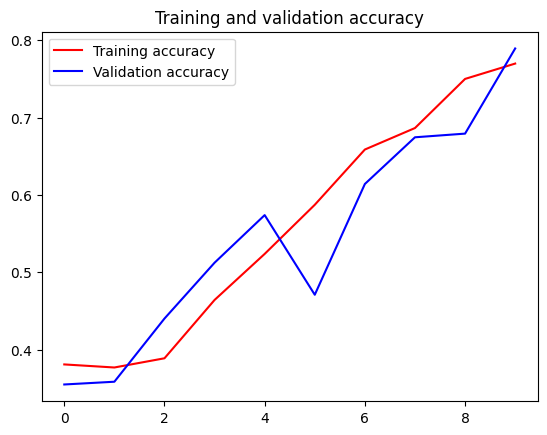

In [221]:
plot_accuracy(history)

The model is under-fitting, and that is predicted because we have a small dataset after applying under-sampling technique, so we'll not use it.

---

## Data Augmentation

Let's try Data Augmentation technique to handle the imbalanced data, and we'll use `ImageDataGenerator` from `tensorflow.keras.preprocessing.image` to do that.

[Source](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)

In [262]:
IMAGES_DIR = "./The IQ-OTHNCCD lung cancer dataset/"

# Define the data generator for training images
training_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    validation_split=0.2,
    rotation_range=10,  # rotation
    width_shift_range=0.2,  # horizontal shift
    height_shift_range=0.2,  # vertical shift
    zoom_range=0.2,  # zoom
    horizontal_flip=True,  # horizontal flip
    brightness_range=[0.2, 1.2],
)

# Generate batches of augmented training data
train_generator = training_datagen.flow_from_directory(
    IMAGES_DIR,
    target_size=(128, 128),
    color_mode='grayscale',
    class_mode="categorical",
    subset="training",  # Specify that this is the training subset
)

# Generate batches of augmented validation data
validation_generator = training_datagen.flow_from_directory(
    IMAGES_DIR,
    target_size=(128, 128),
    color_mode='grayscale',
    class_mode="categorical",
    subset="validation",  # Specify that this is the validation subset
)

Found 878 images belonging to 3 classes.
Found 219 images belonging to 3 classes.


In [269]:
model2 = Sequential()
# Input Layer
model2.add(Input(shape=(train_generator.image_shape)))
# Hidden Layers
model2.add(Conv2D(filters=64, kernel_size=(3, 3), name="conv2d_1", activation="relu"))
model2.add(MaxPooling2D(pool_size=(2, 2), name="max2d_1"))

model2.add(Conv2D(filters=32, kernel_size=(3, 3), name="conv2d_2", activation="relu"))
model2.add(MaxPooling2D(pool_size=(2, 2), name="max2d_2"))

model2.add(Conv2D(filters=8, kernel_size=(3, 3), name="conv2d_3", activation="relu"))
model2.add(MaxPooling2D(pool_size=(2, 2), name="max2d_3"))

model2.add(Flatten(name="flatten"))

# Output Layer
model2.add(Dense(3, activation="softmax", name="out"))

model2.summary()

Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 126, 126, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max2d_1 (MaxPooling2D)          │ (None, 63, 63, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 61, 61, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max2d_2 (MaxPooling2D)          │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 8)      │         2,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max2d_3 (MaxPooling2D)          │ (None, 14, 14, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1568)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ out (Dense)                     │ (None, 3)              │         4,707 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,123 (102.04 KB)

 Trainable params: 26,123 (102.04 KB)

 Non-trainable params: 0 (0.00 B)

In [271]:
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [272]:
history = model2.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
)

Epoch 1/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 24s 681ms/step - accuracy: 0.4581 - loss: 1.0240 - val_accuracy: 0.5114 - val_loss: 0.9686
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 24s 788ms/step - accuracy: 0.5130 - loss: 0.9694 - val_accuracy: 0.5114 - val_loss: 0.9623
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 21s 676ms/step - accuracy: 0.4880 - loss: 0.9615 - val_accuracy: 0.5114 - val_loss: 0.9633
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 19s 626ms/step - accuracy: 0.4969 - loss: 0.9592 - val_accuracy: 0.5114 - val_loss: 1.0013
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 19s 600ms/step - accuracy: 0.5183 - loss: 0.9488 - val_accuracy: 0.5068 - val_loss: 0.9648
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 19s 615ms/step - accuracy: 0.5020 - loss: 0.9708 - val_accuracy: 0.4932 - val_loss: 0.9552
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 15s 471ms/step - accuracy: 0.5228 - loss: 0.9328 - val_accuracy: 0.5068 - val_loss: 0.9515
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 16s 531ms/step - accuracy: 0.4918 - loss: 0.9528 - val_accu

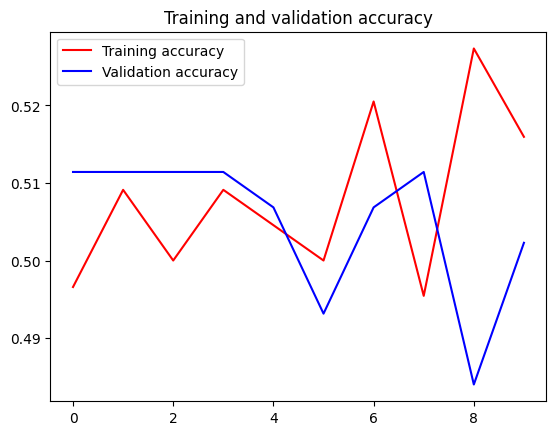

In [273]:
plot_accuracy(history)

The result is not good, and the model is under-fitting, so we'll use the first technique (one-class classification)